Imports

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


Load in the data

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Map inputs to (-1, +1) for better training

In [3]:
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape", x_train.shape)

x_train.shape (60000, 28, 28)


Flatten the data

In [4]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

Dimensionality of the latent space

In [5]:
latent_dim = 100

Get the generator model

In [6]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

Get the discriminator

In [7]:
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

Compile both models in preparation for training

In [8]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noice throudh generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
) 

Train the GAN

In [9]:
# Config
batch_size = 32
epochs=30000
sample_period = 200 # every sample_period steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to stire generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


A function to generate a grid of random samples from the generator and save them to a file

In [11]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images (-1, +1) -> (0, 1)
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(W, H), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    fig.savefig(f'gan_images/{epoch}.png')
    plt.close()


Main training loop

In [12]:
for epoch in range(epochs):
    ### TRAIN DISCRIMINATOR

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    ### TRAIN GENERATOR
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # do it again, since discriminator is trained two times in one epoch
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch + 1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % sample_period == 0:
        sample_images(epoch)

1/1 [==============================] - 0s 168ms/step
epoch: 1/30000, d_loss: 0.82, d_acc: 0.36, g_loss: 0.96
1/1 [==============================] - 0s 17ms/step
epoch: 101/30000, d_loss: 0.06, d_acc: 1.00, g_loss: 3.78
1/1 [==============================] - 0s 17ms/step
epoch: 201/30000, d_loss: 0.54, d_acc: 0.70, g_loss: 1.50
1/1 [==============================] - 0s 21ms/step
epoch: 301/30000, d_loss: 0.71, d_acc: 0.45, g_loss: 0.61
1/1 [==============================] - 0s 16ms/step
epoch: 401/30000, d_loss: 0.69, d_acc: 0.47, g_loss: 0.63
1/1 [==============================] - 0s 18ms/step
epoch: 501/30000, d_loss: 0.69, d_acc: 0.44, g_loss: 0.67
1/1 [==============================] - 0s 20ms/step
epoch: 601/30000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.68
1/1 [==============================] - 0s 19ms/step
epoch: 701/30000, d_loss: 0.65, d_acc: 0.59, g_loss: 0.70
1/1 [==============================] - 0s 19ms/step
epoch: 801/30000, d_loss: 0.66, d_acc: 0.53, g_loss: 0.72
1/1 [======

Plot losses per iteration

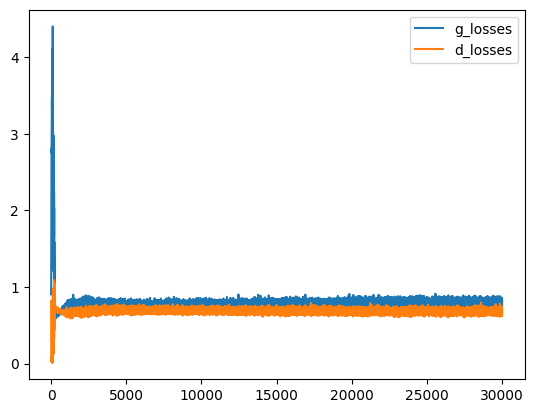

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

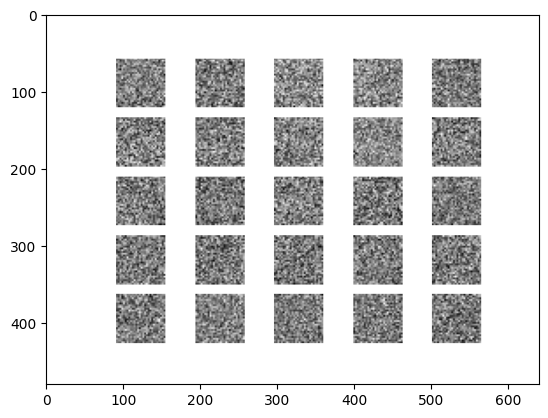

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

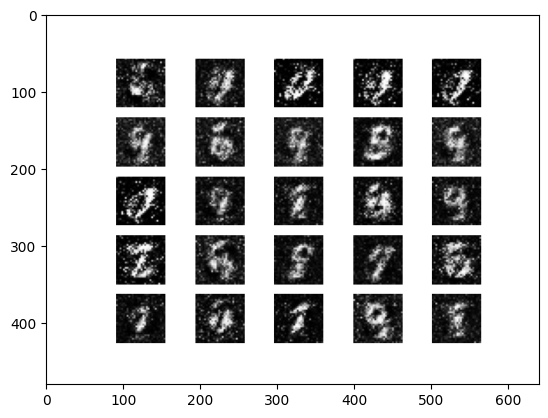

In [15]:
a = imread('gan_images/1000.png')
plt.imshow(a)

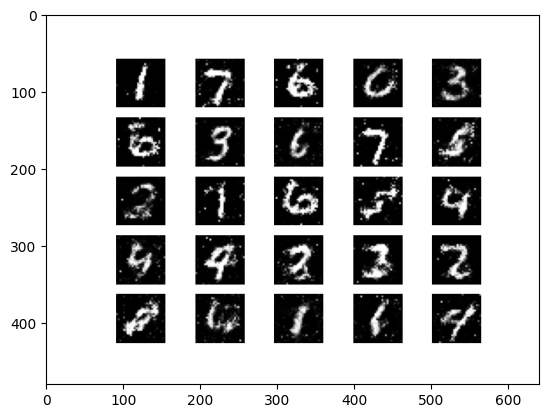

In [16]:
a = imread('gan_images/5000.png')
plt.imshow(a)

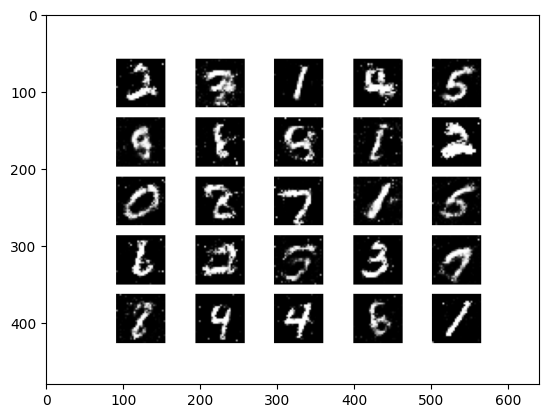

In [17]:
a = imread('gan_images/10000.png')
plt.imshow(a)

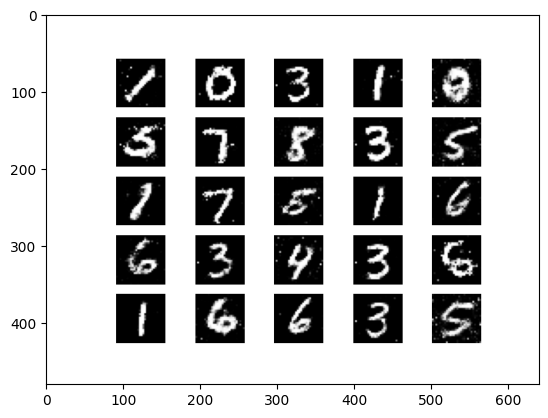

In [18]:
a = imread('gan_images/20000.png')
plt.imshow(a)

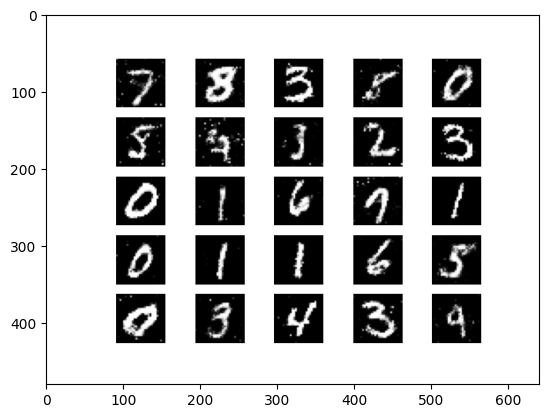

In [19]:
a = imread('gan_images/29800.png')
plt.imshow(a)